In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# For deep learning
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing as keras_preprocessing

print(tf.__version__)


2.4.1


In [ ]:
# for when working in google colab
from google.colab import drive
drive.mount('/content/drive/')

In [3]:
# import data
# data_file = '/content/drive/MyDrive/6862_project/QCFilteredData.csv'
data_file = 'data/GOSHIP_Data/QCFilteredData.csv'
### ignore lat lon for now. Add later after zoning
### ignore month for now. One-hot encode later
data = pd.read_csv(data_file, header=0, usecols=[3,4,5,6,7,8,9,10,11], 
                   names=['lat','lon','pres','temp','sal','oxy','nitr','phsp','sili'])

In [4]:
# split data into training, validation, testing set
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)


In [5]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_phsp = train_features.pop('phsp')
test_phsp = test_features.pop('phsp')

train_sili = train_features.pop('sili')
test_sili = test_features.pop('sili')

In [6]:
train_features.describe().transpose()[['mean', 'std']]


,mean,std
lat,-59.903027,7.542840
lon,3.140392,118.452406
pres,1264.076808,1299.684429
temp,1.689565,2.498022
sal,34.508702,0.300963
oxy,230.972748,50.322881
nitr,29.910701,5.162313


In [7]:
normalizer = keras_preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

In [8]:
# create dropout layer
# from tensorflow.keras.layers.core import Lambda
from tensorflow.keras import backend as K

def PermaDropout(rate):
    return keras.layers.Lambda(lambda x: K.dropout(x, level=rate))

In [9]:
# with permaDropout
linear_model_phsp = tf.keras.Sequential([
    normalizer, PermaDropout(0.2),
    layers.Dense(units=1)
])

linear_model_phsp.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

history = linear_model_phsp.fit(
    train_features, train_phsp, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
849/849 [==============================] - 2s 2ms/step - loss: 5.3603 - val_loss: 1.9364
Epoch 2/100
849/849 [==============================] - 1s 917us/step - loss: 1.4798 - val_loss: 0.5331
Epoch 3/100
849/849 [==============================] - 1s 1ms/step - loss: 0.3878 - val_loss: 0.1081
Epoch 4/100
849/849 [==============================] - 1s 926us/step - loss: 0.0748 - val_loss: 0.0247
Epoch 5/100
849/849 [==============================] - 1s 897us/step - loss: 0.0221 - val_loss: 0.0167
Epoch 6/100
849/849 [==============================] - 1s 1ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 7/100
849/849 [==============================] - 1s 1ms/step - loss: 0.0178 - val_loss: 0.0170
Epoch 8/100
849/849 [==============================] - 1s 874us/step - loss: 0.0185 - val_loss: 0.0176
Epoch 9/100
849/849 [==============================] - 1s 897us/step - loss: 0.0180 - val_loss: 0.0172
Epoch 10/100
849/849 [==============================] - 1s 868us/step - loss: 0.0

Epoch 80/100
849/849 [==============================] - 1s 845us/step - loss: 0.0194 - val_loss: 0.0170
Epoch 81/100
849/849 [==============================] - 1s 848us/step - loss: 0.0172 - val_loss: 0.0173
Epoch 82/100
849/849 [==============================] - 1s 846us/step - loss: 0.0188 - val_loss: 0.0171
Epoch 83/100
849/849 [==============================] - 1s 892us/step - loss: 0.0179 - val_loss: 0.0171
Epoch 84/100
849/849 [==============================] - 1s 849us/step - loss: 0.0186 - val_loss: 0.0166
Epoch 85/100
849/849 [==============================] - 1s 882us/step - loss: 0.0175 - val_loss: 0.0170
Epoch 86/100
849/849 [==============================] - 1s 882us/step - loss: 0.0186 - val_loss: 0.0171
Epoch 87/100
849/849 [==============================] - 1s 905us/step - loss: 0.0174 - val_loss: 0.0167
Epoch 88/100
849/849 [==============================] - 1s 874us/step - loss: 0.0190 - val_loss: 0.0179
Epoch 89/100
849/849 [==============================] - 1s 910us

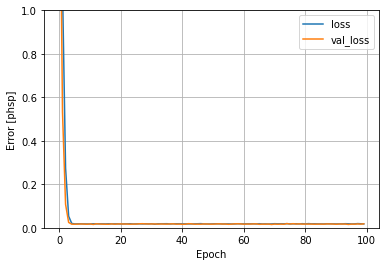

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)

In [11]:
# predict phsp with dropout (100 times)
predictions_lst = []
for i in range(100):
    test_predictions = linear_model_phsp.predict(test_features).flatten()
    predictions_lst.append(test_predictions)

In [12]:
# get means and standard deviations
linear_phsp_arr = np.array(predictions_lst)
linear_phsp_mean = np.mean(linear_phsp_arr, axis=0)
linear_phsp_sd = np.std(linear_phsp_arr, axis=0)

Text(0, 0.5, 'Predictions [phsp]')

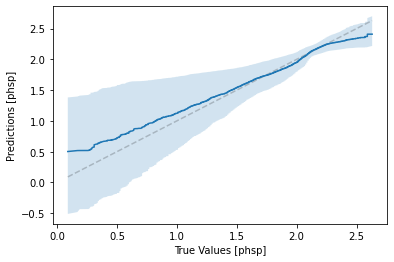

In [13]:
# plot confidence intervals
min_val = np.min(test_phsp)
max_val = np.max(test_phsp)
fig, ax = plt.subplots()
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.plot(np.sort(test_phsp), np.sort(linear_phsp_mean))
ax.fill_between(np.sort(test_phsp), np.sort(linear_phsp_mean - 1.96*linear_phsp_sd), 
                np.sort(linear_phsp_mean + 1.96*linear_phsp_sd), alpha=0.2)
plt.xlabel('True Values [phsp]')
plt.ylabel('Predictions [phsp]')

In [14]:
# with permaDropout
linear_model_sili = tf.keras.Sequential([
    normalizer, PermaDropout(0.2),
    layers.Dense(units=1)
])

linear_model_sili.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error')

history = linear_model_sili.fit(
    train_features, train_sili, 
    epochs=100,
    # suppress logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Epoch 1/100
849/849 [==============================] - 1s 1ms/step - loss: 7986.8558 - val_loss: 7664.4570
Epoch 2/100
849/849 [==============================] - 1s 997us/step - loss: 7550.1201 - val_loss: 7343.3906
Epoch 3/100
849/849 [==============================] - 1s 939us/step - loss: 7335.1307 - val_loss: 7050.5288
Epoch 4/100
849/849 [==============================] - 1s 966us/step - loss: 7059.1710 - val_loss: 6783.5420
Epoch 5/100
849/849 [==============================] - 1s 876us/step - loss: 6709.0700 - val_loss: 6523.8174
Epoch 6/100
849/849 [==============================] - 1s 918us/step - loss: 6524.4724 - val_loss: 6297.8413
Epoch 7/100
849/849 [==============================] - 1s 967us/step - loss: 6326.4301 - val_loss: 6090.9678
Epoch 8/100
849/849 [==============================] - 1s 973us/step - loss: 6089.1233 - val_loss: 5899.4062
Epoch 9/100
849/849 [==============================] - 1s 871us/step - loss: 5893.8401 - val_loss: 5723.5449
Epoch 10/100
849/849 

Epoch 76/100
849/849 [==============================] - 1s 879us/step - loss: 573.4481 - val_loss: 544.8035
Epoch 77/100
849/849 [==============================] - 1s 867us/step - loss: 533.1955 - val_loss: 511.1046
Epoch 78/100
849/849 [==============================] - 1s 870us/step - loss: 515.3836 - val_loss: 481.3892
Epoch 79/100
849/849 [==============================] - 1s 901us/step - loss: 486.5018 - val_loss: 454.3992
Epoch 80/100
849/849 [==============================] - 1s 853us/step - loss: 455.8718 - val_loss: 438.2675
Epoch 81/100
849/849 [==============================] - 1s 922us/step - loss: 437.7305 - val_loss: 413.1240
Epoch 82/100
849/849 [==============================] - 1s 961us/step - loss: 416.5174 - val_loss: 406.5553
Epoch 83/100
849/849 [==============================] - 1s 992us/step - loss: 400.0990 - val_loss: 389.7451
Epoch 84/100
849/849 [==============================] - 1s 965us/step - loss: 380.4401 - val_loss: 359.0769
Epoch 85/100
849/849 [======

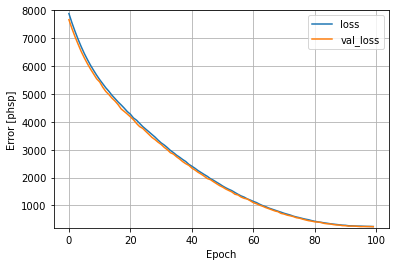

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([200, 8000])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)

In [16]:
# predict sili with dropout (100 times)
predictions_lst = []
for i in range(100):
    test_predictions = linear_model_sili.predict(test_features).flatten()
    predictions_lst.append(test_predictions)

In [17]:
# compute means and standard deviations
linear_sili_arr = np.array(predictions_lst)
linear_sili_mean = np.mean(linear_sili_arr, axis=0)
linear_sili_sd = np.std(linear_sili_arr, axis=0)


Text(0, 0.5, 'Predictions [sili]')

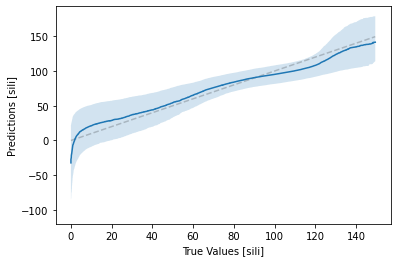

In [18]:
min_val = np.min(test_sili)
max_val = np.max(test_sili)
fig, ax = plt.subplots()
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.plot(np.sort(test_sili), np.sort(linear_sili_mean), '-')
ax.fill_between(np.sort(test_sili), np.sort(linear_sili_mean - 1.96*linear_sili_sd), 
                np.sort(linear_sili_mean + 1.96*linear_sili_sd), alpha=0.2)
plt.xlabel('True Values [sili]')
plt.ylabel('Predictions [sili]')

In [19]:
test_results = {}

test_results['linear_model_phsp'] = linear_model_phsp.evaluate(test_features, test_phsp, verbose=0)

test_results['linear_model_sili'] = linear_model_sili.evaluate(test_features, test_sili, verbose=0)


In [20]:
### DNN regression
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [21]:
# DNN model with permaDropout
def build_and_compile_model_dropout(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      PermaDropout(0.2),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [22]:
dnn_model_phsp = build_and_compile_model_dropout(normalizer)
dnn_model_phsp.summary()

history = dnn_model_phsp.fit(
    train_features, train_phsp,
    validation_split=0.2,
    verbose=1, epochs=100)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
lambda_2 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________
Epoch 1/100
849/849 [==============================] - 2s 1ms/step - loss: 0.4604 - val_loss: 0.0515
Epoch 2/100
849/

849/849 [==============================] - 1s 980us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 72/100
849/849 [==============================] - 1s 999us/step - loss: 0.0034 - val_loss: 0.0031
Epoch 73/100
849/849 [==============================] - 1s 985us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 74/100
849/849 [==============================] - 1s 985us/step - loss: 0.0033 - val_loss: 0.0033
Epoch 75/100
849/849 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 76/100
849/849 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 77/100
849/849 [==============================] - 1s 974us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 78/100
849/849 [==============================] - 1s 972us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 79/100
849/849 [==============================] - 1s 996us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 80/100
849/849 [==============================] - 1s 980us/step - loss: 0.0

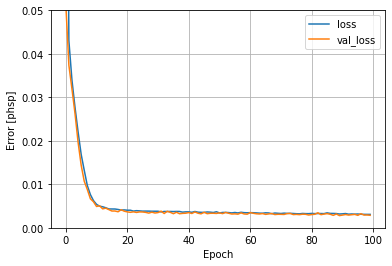

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0.0, 0.05])
plt.xlabel('Epoch')
plt.ylabel('Error [phsp]')
plt.legend()
plt.grid(True)


In [24]:
# predict phsp with dropout (100 times)
predictions_lst = []
for i in range(100):
    test_predictions = dnn_model_phsp.predict(test_features).flatten()
    predictions_lst.append(test_predictions)

In [25]:
# compute means and standard deviations
dnn_phsp_arr = np.array(predictions_lst)
dnn_phsp_mean = np.mean(dnn_phsp_arr, axis=0)
dnn_phsp_sd = np.std(dnn_phsp_arr, axis=0)

Text(0, 0.5, 'Predictions [phsp]')

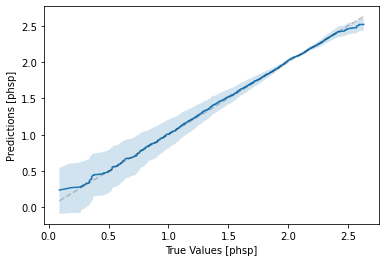

In [26]:
min_val = np.min(test_phsp)
max_val = np.max(test_phsp)
fig, ax = plt.subplots()
ax.plot(np.sort(test_phsp), np.sort(dnn_phsp_mean), '-')
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.fill_between(np.sort(test_phsp), np.sort(dnn_phsp_mean - 1.96*dnn_phsp_sd), 
                np.sort(dnn_phsp_mean + 1.96*dnn_phsp_sd), alpha=0.2)
plt.xlabel('True Values [phsp]')
plt.ylabel('Predictions [phsp]')

In [27]:
dnn_model_sili = build_and_compile_model_dropout(normalizer)
dnn_model_sili.summary()

history = dnn_model_sili.fit(
    train_features, train_sili,
    validation_split=0.2,
    verbose=1, epochs=100)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
lambda_3 (Lambda)            (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________
Epoch 1/100
849/849 [==============================] - 1s 1ms/step - loss: 3022.4442 - val_loss: 125.8054
Epoch 2/100

849/849 [==============================] - 1s 1ms/step - loss: 57.6130 - val_loss: 58.4423
Epoch 70/100
849/849 [==============================] - 1s 1ms/step - loss: 57.5274 - val_loss: 59.0162
Epoch 71/100
849/849 [==============================] - 1s 1ms/step - loss: 58.5579 - val_loss: 60.9706
Epoch 72/100
849/849 [==============================] - 1s 1ms/step - loss: 57.8542 - val_loss: 57.2694
Epoch 73/100
849/849 [==============================] - 1s 1ms/step - loss: 56.0462 - val_loss: 56.3485
Epoch 74/100
849/849 [==============================] - 1s 1ms/step - loss: 56.5823 - val_loss: 55.7068
Epoch 75/100
849/849 [==============================] - 1s 1ms/step - loss: 55.4466 - val_loss: 57.5532
Epoch 76/100
849/849 [==============================] - 1s 1ms/step - loss: 57.3105 - val_loss: 56.2079
Epoch 77/100
849/849 [==============================] - 1s 1ms/step - loss: 55.9031 - val_loss: 56.8545
Epoch 78/100
849/849 [==============================] - 1s 1ms/step - loss: 5

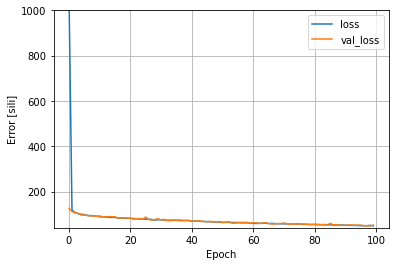

In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([40, 1000])
plt.xlabel('Epoch')
plt.ylabel('Error [sili]')
plt.legend()
plt.grid(True)


In [29]:
# predict sili with dropout (100 times)
predictions_lst = []
for i in range(100):
    test_predictions = dnn_model_sili.predict(test_features).flatten()
    predictions_lst.append(test_predictions)

In [30]:
# compute means and standard deviations
dnn_sili_arr = np.array(predictions_lst)
dnn_sili_mean = np.mean(dnn_sili_arr, axis=0)
dnn_sili_sd = np.std(dnn_sili_arr, axis=0)

Text(0, 0.5, 'Predictions [sili]')

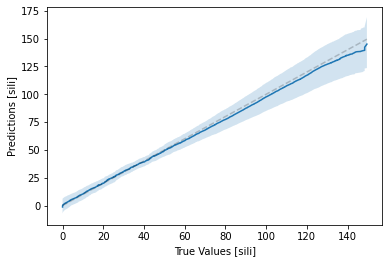

In [31]:
min_val = np.min(test_sili)
max_val = np.max(test_sili)
fig, ax = plt.subplots()
ax.plot(np.sort(test_sili), np.sort(dnn_sili_mean), '-')
diag_line = ax.plot(np.linspace(min_val,max_val,100),np.linspace(min_val,max_val,100), 'k--', alpha=0.2)
ax.fill_between(np.sort(test_sili), np.sort(dnn_sili_mean - 1.96*dnn_sili_sd), 
                np.sort(dnn_sili_mean + 1.96*dnn_sili_sd), alpha=0.2)
plt.xlabel('True Values [sili]')
plt.ylabel('Predictions [sili]')

In [32]:
# save errors
test_results['dnn_phsp_model'] = dnn_model_phsp.evaluate(test_features, test_phsp, verbose=0)

test_results['dnn_sili_model'] = dnn_model_sili.evaluate(test_features, test_sili, verbose=0)

In [33]:
pd.DataFrame(test_results, index=['Mean squared error']).T

,Mean squared error
linear_model_phsp,0.019183
linear_model_sili,243.012985
dnn_phsp_model,0.003122
dnn_sili_model,49.607903


Text(0, 0.5, 'predicted sili')

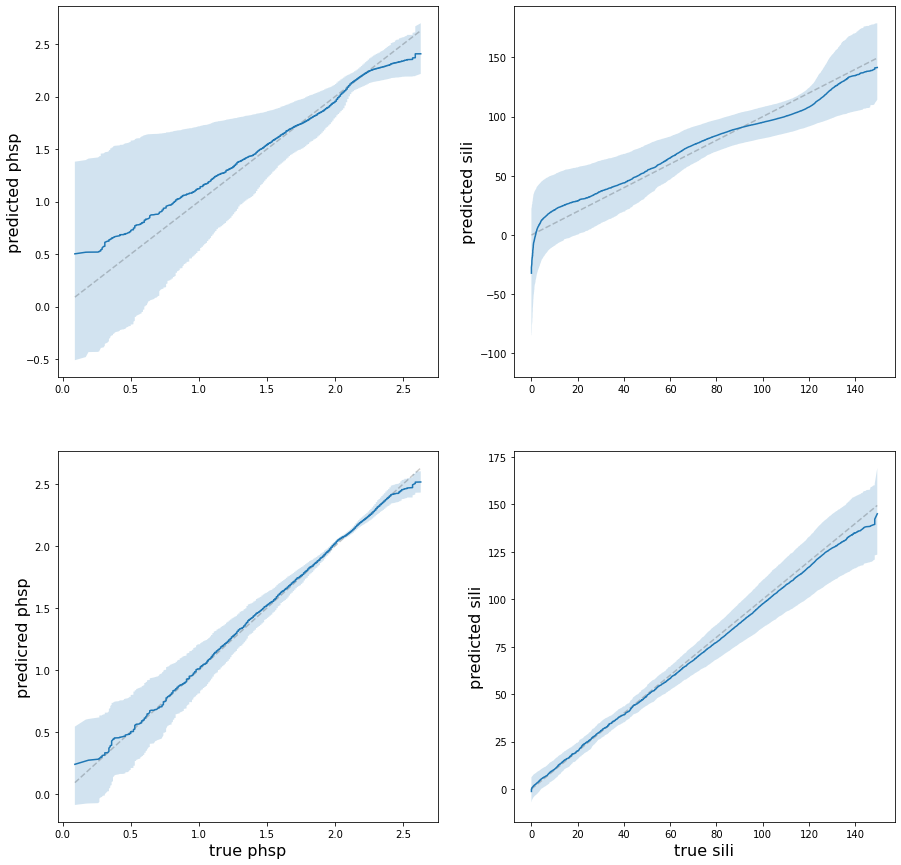

In [34]:
min_phsp = np.min(test_phsp)
max_phsp = np.max(test_phsp)
min_sili = np.min(test_sili)
max_sili = np.max(test_sili)


fig, axs = plt.subplots(2, 2, figsize=(15,15))

# regression phsp
axs[0, 0].plot(np.linspace(min_phsp,max_phsp,100),np.linspace(min_phsp,max_phsp,100), 'k--', alpha=0.2)
axs[0, 0].plot(np.sort(test_phsp), np.sort(linear_phsp_mean))
axs[0, 0].fill_between(np.sort(test_phsp), np.sort(linear_phsp_mean - 1.96*linear_phsp_sd), 
                np.sort(linear_phsp_mean + 1.96*linear_phsp_sd), alpha=0.2)
# axs[0, 0].set_title('Axis [0, 0]')

# regression sili
axs[0, 1].plot(np.linspace(min_sili,max_sili,100),np.linspace(min_sili,max_sili,100), 'k--', alpha=0.2)
axs[0, 1].plot(np.sort(test_sili), np.sort(linear_sili_mean))
axs[0, 1].fill_between(np.sort(test_sili), np.sort(linear_sili_mean - 1.96*linear_sili_sd), 
                np.sort(linear_sili_mean + 1.96*linear_sili_sd), alpha=0.2)

# dnn phsp
axs[1, 0].plot(np.linspace(min_phsp,max_phsp,100),np.linspace(min_phsp,max_phsp,100), 'k--', alpha=0.2)
axs[1, 0].plot(np.sort(test_phsp), np.sort(dnn_phsp_mean))
axs[1, 0].fill_between(np.sort(test_phsp), np.sort(dnn_phsp_mean - 1.96*dnn_phsp_sd), 
                np.sort(dnn_phsp_mean + 1.96*dnn_phsp_sd), alpha=0.2)

# dnn sili
axs[1, 1].plot(np.linspace(min_sili,max_sili,100),np.linspace(min_sili,max_sili,100), 'k--', alpha=0.2)
axs[1, 1].plot(np.sort(test_sili), np.sort(dnn_sili_mean))
axs[1, 1].fill_between(np.sort(test_sili), np.sort(dnn_sili_mean - 1.96*dnn_sili_sd), 
                np.sort(dnn_sili_mean + 1.96*dnn_sili_sd), alpha=0.2)

# axs[0, 1].set_title('Axis [0, 1]')
# axs[1, 0].plot(x, -y, 'tab:green')
# axs[1, 0].set_title('Axis [1, 0]')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')

axs[1,0].set_xlabel('true phsp', fontsize=16)
axs[0,0].set_ylabel('predicted phsp', fontsize=16)
axs[1,0].set_ylabel('predicred phsp', fontsize=16)
axs[1,1].set_xlabel('true sili', fontsize=16)
axs[0,1].set_ylabel('predicted sili', fontsize=16)
axs[1,1].set_ylabel('predicted sili', fontsize=16)

# for ax in axs.flat:
#     ax.set(xlabel='true', ylabel='predicted')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()